# Exercises Sheet 1 - Simulations

## 1. Calculate $\pi$ using Monte Carlo

In [57]:
# x^2 + y^2 <= r^2
function calculate_pi(N = 1000)
    S = 0
    x, y = rand(N), rand(N)
    c    = zeros(N)
    for i in 1:N
        if x[i]^2+y[i]^2 <= 1
            S+=1
            c[i] = 1
        end
    end
    π = 4*S/N
    return π,x,y,c
end

calculate_pi (generic function with 2 methods)

In [74]:
N = [100,1_000,10_000,100_000]
v,x,y,c = calculate_pi(100_000)

(3.14844, [0.442576, 0.649958, 0.597248, 0.533039, 0.951358, 0.899891, 0.173083, 0.576374, 0.0157637, 0.0737557  …  0.428952, 0.894879, 0.729769, 0.3906, 0.301704, 0.881323, 0.623414, 0.815187, 0.980286, 0.00259974], [0.110921, 0.472172, 0.893882, 0.457185, 0.507337, 0.00782023, 0.263965, 0.971974, 0.705898, 0.729743  …  0.828711, 0.335491, 0.54738, 0.258999, 0.218623, 0.827373, 0.429945, 0.940723, 0.692856, 0.91753], [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0])

In [59]:
using Plots; pyplot()

Plots.PyPlotBackend()

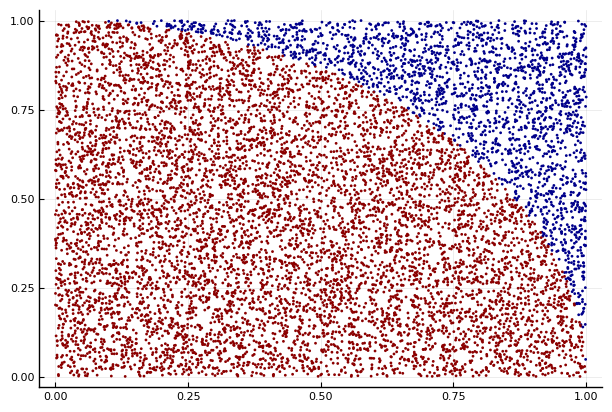

In [71]:
p = scatter(x,y,zcolor=c,markersize=2,markerstrokewidth = 0,c=:bluesreds,fmt =:png,legend=false)
savefig(p,"./images/Ex1.png")

## 2. *Box-Muller*

In [742]:
function box_muller(N=100)
    R = (-2*log.(rand(N))).^(1/2)
    v = 2*π*rand(N)
    X = R.*cos.(v)
    Y = R.*sin.(v)
    return X,Y
end

box_muller (generic function with 2 methods)

In [753]:
v = box_muller(10000)
h1 = histogram(v[1],alpha=0.5,label="X")
h2 = histogram!(v[end],alpha=0.5,label="Y")
s  = plot(v[1],v[end],seriestype=:scatter,markerstrokewidth=0,alpha=0.1,ylabel="Y",xlabel="X",legend=false)
p  = plot(h2,s,layout=2)
savefig(p,"./images/Ex2.png")

## 3. Genetic Linkage Model

Solução numérica

0.57	1.8594222944881917e18

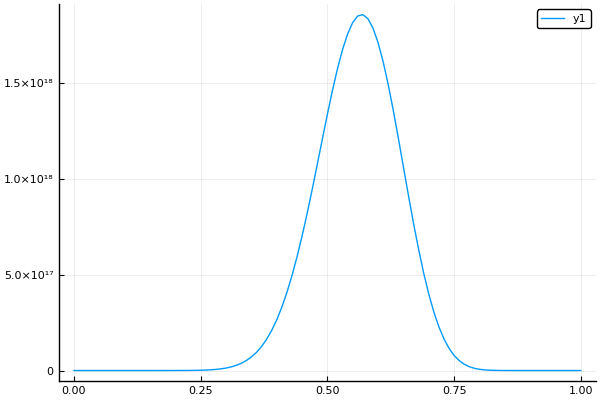

In [75]:
# using Distributions
post(θ,y) = ((2+θ)^y[1])*((1-θ)^(y[2]+y[3]))*θ^y[4]
v = [1,2,3,4]
post(0.1,v)

y = [69,9,11,11]
x = collect(0:0.01:1);
posterior = post.(x,Ref(y));
xmax = x[argmax(posterior)]
vmax = maximum(posterior)
print(xmax,"\t",vmax)
plot(x,posterior)

Solução simbólica

In [76]:
using SymPy
using LaTeXStrings

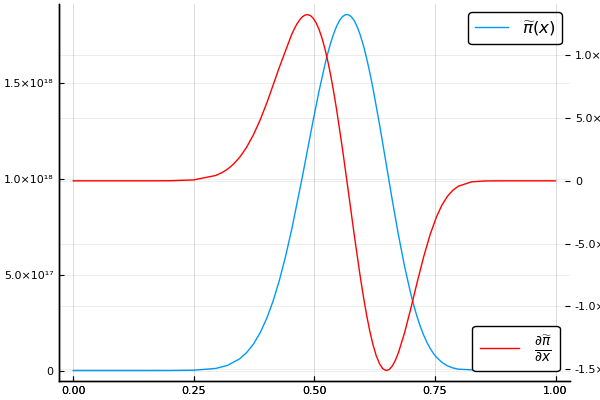

In [77]:
x  = symbols("x", real=true)
ex = ((2+x)^y[1])*((1-x)^(y[2]+y[3]))*x^y[4]
p1 = plot(ex, 0,1 ,label=L"\widetilde{\pi}(x)",legendfont=12)
p2 = plot!(twinx(),diff(ex), 0,1, label=L"\frac{\partial \widetilde{\pi}}{\partial x}",
    color="red",legend=:bottomright, legendfont=14)

In [78]:
solution = solve(diff(ex))
argmle = SymPy.N(solution[5])
mle    = round(SymPy.N(ex.subs(x,argmle)))

1.860237025726715232e+18

In [79]:
# Testando 10 de uma vez - somente um exemplo
x = rand(10)
u = rand(10)
aceitos = x[u .<= post.(x,Ref(y))]

10-element Array{Float64,1}:
 0.33825629304559435
 0.728726569783203  
 0.24746488828204471
 0.5761467315506734 
 0.09116463207657577
 0.5888563139400136 
 0.7046472562991111 
 0.8434024374056863 
 0.34705273677450776
 0.35741696389611755

In [80]:
function rejection_sampling(N=1000)
    post(θ,y) = ((2+θ)^y[1])*((1-θ)^(y[2]+y[3]))*θ^y[4]
    y = [69,9,11,11]
    size = 0
    sample = zeros(N)
    T = zeros(0)
    t = 0
    while size < N
        x = rand()
        u = rand()
        if u <= post(x,y)/mle
            size+=1
            sample[size] = x
            append!(T , t)
            t = 0
        end
        t += 1
        
    end
    return sample, T
end

rejection_sampling (generic function with 3 methods)

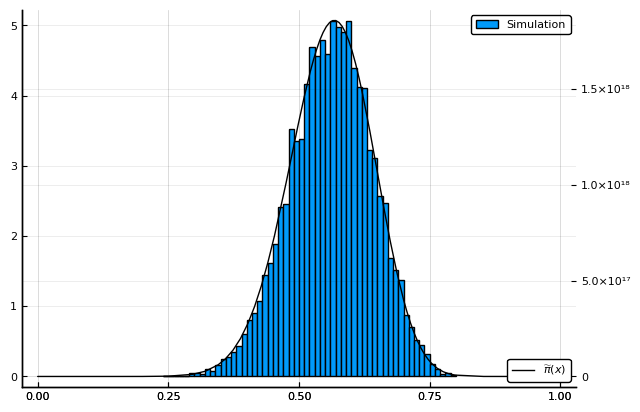

In [99]:
sample, T = rejection_sampling(10_000) 
histogram(sample,normalize=true, label="Simulation")
p = plot!(twinx(),ex, 0,1 ,label=L"\widetilde{\pi}(x)",color="black",legend=:bottomright)
savefig(p,"./images/Ex3_1.png")

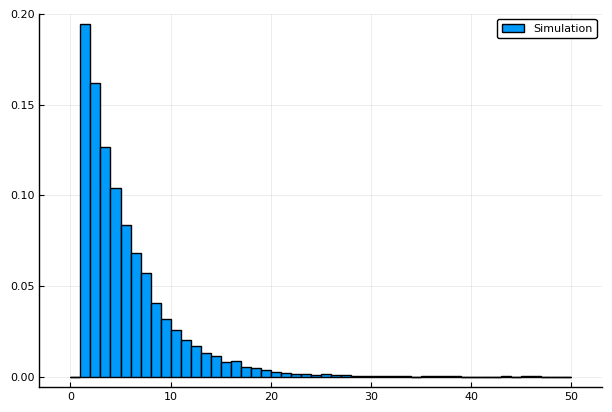

In [100]:
p = histogram(T,normalize=true, label="Simulation",bins=0:maximum(T))
savefig(p,"./images/Ex3_2.png")

## 4. Mixture of Gaussians

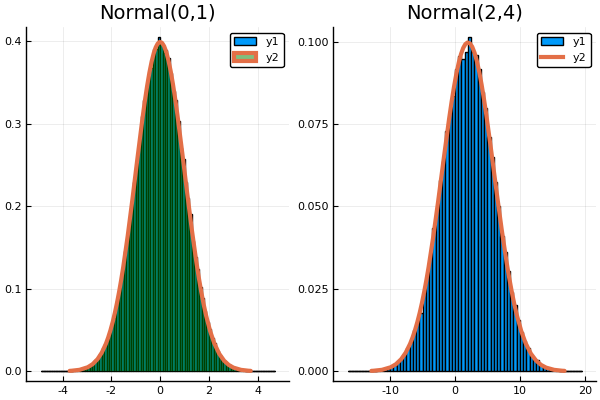

In [101]:
using Distributions
using StatsPlots
p1 = (histogram(box_muller(10_0000)[1],normalized=true, title="Normal(0,1)"); plot!(Normal(0,1),fill=(0,0.5,:green),linewidth = 3));
# histogram!(randn(10_0000),alpha=0.5,normalized=true)
μ = 2
σ = 4
p2 = (histogram(σ.*box_muller(100_000)[1].+μ,normalized=true,title="Normal(2,4)"); plot!(Normal(μ,σ),linewidth = 3));

plot(p1,p2)

In [754]:
function mixture(N=1000,mix_rate=0.5,μ1=0,σ1=1,μ2=0,σ2=1)
    W   = rand(N) .<= (1-mix_rate)
    X,Y = box_muller(N)
    X   = σ1.*X .+ μ1
    Y   = σ2.*Y .+ μ2
    Mix = (X).*(W*1) + Y.*(.!W*1)
    return Mix
end

# mix = collect(0:0.2:1)
mix = collect(0.5)
h = histogram(mixture.(Ref(100_000),mix,Ref(0),Ref(1),Ref(5),Ref(2)),alpha=0.5,label=mix,nbins=100)
savefig(h, "./images/Ex4.png")

## 5. Monte Carlo

Calculando o resultado analítico da funcao. 

-cos(20)/20 + sin(50)/50 + 1/20 = 2.434839983525182497859873401536530122730170518476258840335731821647793935411972e-02


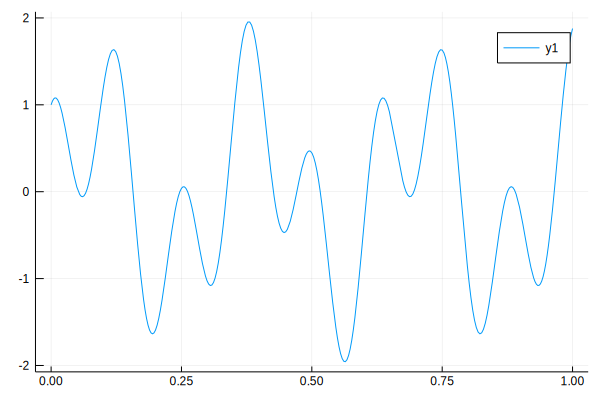

In [755]:
x  = symbols("x")
eq = cos(50*x)+sin(20*x)
I  = integrate(eq,(x,0,1)) # valor simbolico da integral 
Iv = SymPy.N(I)            # valor numerico da integral
println(I," = ",Iv)
plot(eq,0,1)

Como a equação adquire valores negativos, iremos somar 2 e depois subtrair.

In [383]:
function rejection_sampling(N=1000,M=4)
    f(x) = cos(50*x)+sin(20*x)+2
    size = 0
    sample = zeros(N)
    T = zeros(0)
    t = 0
    while size < N
        x = rand()
        u = rand()
        if u <= f(x)/M
            size+=1
            sample[size] = x
            append!(T , t)
            t = 0
        end
        t += 1
        
    end
    return sample, T
end


rejection_sampling (generic function with 3 methods)

In [806]:
erro = 0
for i = 1:10
    N = 1_000_000
    sample, T = rejection_sampling.(N)
    erro += abs(N / sum(T)*4 - 2 - Iv)/Iv*100
end

error = erro/10

4.312898504364390603568669944658595992366382403721601903347405436145767187205157

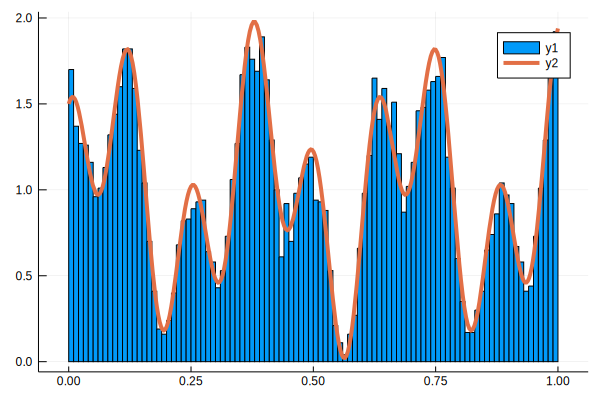

In [385]:
sample, T = rejection_sampling(10_000) 
histogram(sample,bins=0:0.01:1,normalized=true)
plot!((eq+2)/2,0,1,linewidth=4)

Utilizando importante sampling.

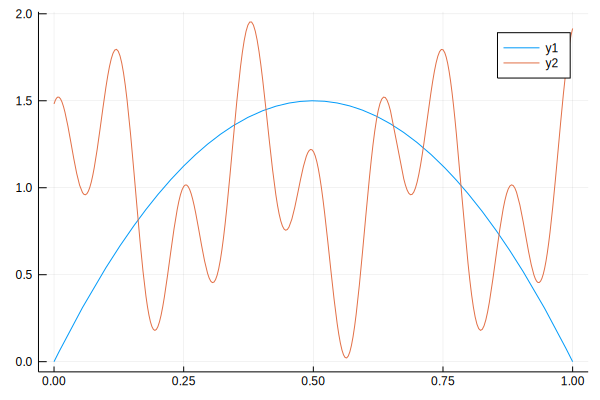

In [760]:
plot(Distributions.Beta(2,2))
plot!((eq+2)/(Iv+2),0,1)

In [808]:
f(x) = cos(50*x)+sin(20*x)
error = 0
for i = 1:10
    N = 1_000_000
    sample = rand(Distributions.Beta(2,2),N)
    q(x)   = Distributions.pdf(Beta(2,2),x)
    w   = exp.(-log.(q.(sample)))
    error += abs(sum(f.(sample)'* w)/N - Iv)*100
end

error = error / 10

2.987844099296845503446107345692719345188210070765994243171463643295587870823965e-01